# 25 Days of DAX Fridays! Challenge - Edition 3

Notebook author: Nelson López Centeno

In this Python notebook, I present my responses to the [challenge created by Ruth Pozuelo (Curbal)](https://curbal.com/25-days-of-dax-fridays-challenge-edition-3).

This notebook must be run in Microsoft Fabric. Create a new workspace, import this notebook, and run all the cells.

The notebook is divided into two parts:  
1. **Preparations**: In this part, the PBIX file shared by Ruth is downloaded and published to the workspace. Additionally, a list is defined with all the questions and expected answers, along with several utility functions.  
2. **Responses**: There is a pair of cells for each question. A markdown cell contains the question and a link to Ruth's video with the answer. A code cell contains the DAX expression with my solution, which is passed to a utility function to execute it in the published model, display a table with the result, and compare it with the expected value.  


## Preparations

#### Importing Python libraries

In [116]:
import requests
import zipfile
import io
import time

import sempy.fabric as fabric
from sempy.relationships import plot_relationship_metadata

from powerbiclient import Report

from rich.table import Table
from rich.jupyter import print as rich_print

#### Creating a list with the questions and expected answers

In [117]:
QUESTIONS = [
    {
        "question": "Day 01: Which product/s has been ordered the most (in terms of quantity)?",
        "expected": "Camembert Pierrot"
    },
    {
        "question": "Day 02: Which product/s has have the highest average order size??",
        "expected": "Schoggi Schokolade"
    },
    {
        "question": "Day 03: What is the highest average discount done to a product? (in %)",
        "expected": "25%"
    },
    {
        "question": "Day 04: Top 3 categories that have the highest revenue contribution",
        "expected": "Beverages, Dairy Products, Confections"
    },
    {
        "question": "Day 05: Average price of discountined products",
        "expected": "44.35"
    },
    {
        "question": "Day 06: Percentage of sales of discountined products",
        "expected": "15%"
    },
    {
        "question": "Day 07: How many high-value orders wrer place in 1997?",
        "expected": "145"
    },
    {
        "question": "Day 08: Number of orders delivered on time",
        "expected": "3"
    },
    {
        "question": "Day 09: Single month with highest sales",
        "expected": "Apr"
    },
    {
        "question": "Day 10: Best sales date for queso cabrales",
        "expected": "Tue"
    },
    {
        "question": "Day 11: Customer/s with the highest customer lifespan",
        "expected": "Richter Supermarkt"
    },
    {
        "question": "Day 12: Which customer/s has placed the most orders?",
        "expected": "Save-a-lot Markets"
    },
    {
        "question": "Day 13: Top 5 countries with the highest number of customers",
        "expected": "USA, Germany, France, Brazil, UK"
    },
    {
        "question": "Day 14: Which customer/s placed the highest value of orders (in sales) in 1997?",
        "expected": "QUICK-Stop"
    },
    {
        "question": "Day 15: Customer/s with the highest number of orders in one single month",
        "expected": "Bottom-Dollar Markets, Ernst Handel, Save-a-lot Markets"
    },
    {
        "question": "Day 16: Employee/s with the highest average order value (in sales)",
        "expected": "Anne Dodsworth"
    },
    {
        "question": "Day 17: Employee/s with the langest avg processing order time",
        "expected": "Anne Dodsworth"
    },
    {
        "question": "Day 18: Which employee has been in the company the longest?",
        "expected": "Janet Leverling"
    },
    {
        "question": "Day 19: Names of all Northwind managers",
        "expected": "Andrew Fuller, Nancy Davolio, Steven Buchanan"
    },
    {
        "question": "Day 20: Which employee/s handles most unique customers?",
        "expected": "Margaret Peacock"
    },
    {
        "question": "Day 21: Number of suppliers that deliver more products than average",
        "expected": "16"
    },
    {
        "question": "Day 22: Which supplier/s has the most out-of-stock products",
        "expected": "Formaggi Fortini s.r.l., G'day, Mate, New Orleans Cajun Delights, Pavlova, Ltd., Plutzer Lebensmittelgroßmärkte AG"
    },
    {
        "question": "Day 23: Which supplier delivers the most expensive product?",
        "expected": "Aux joyeux ecclésiastiques"
    },
    {
        "question": "Day 24: Which supplier has the highest category diversity?",
        "expected": "Pavlova, Ltd., Plutzer Lebensmittelgroßmärkte AG"
    },
    {
        "question": "Day 25: Supplier with highest number of top 5 selling products",
        "expected": "Gai pâturage"
    }
]

#### Defining utility functions

In [118]:
def download_and_publish_pbix(workspace_id):
    """ Download the ZIP file with the PBIX shared by Ruth and publish it to a workspace.
    """ 
    r = requests.get("https://curbal.com/wp-content/uploads/2024/11/Northwind-challenge_exercise-file_Ed3.zip")

    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        pbix_name = z.filelist[0].filename
        pbix = z.read(pbix_name)

        files = { "file": pbix }
        
        pbi = fabric.PowerBIRestClient()
        pbi.post(f"v1.0/myorg/groups/{workspace_id}/imports?datasetDisplayName={pbix_name}&nameConflict=CreateOrOverwrite ", files=files)    

def get_report(workspace_id):
    """ Get the ID of the first report found in a workspace.
    """
    pbi = fabric.PowerBIRestClient()
    r = pbi.get(f"/v1.0/myorg/groups/{workspace_id}/reports")
    reports = r.json()['value']
    return reports[0]

def get_dataset(workspace_id) :
    """ Get the ID of the first dataset (semantic model) found in a workspace.
    """
    pbi = fabric.PowerBIRestClient()
    r = pbi.get(f"/v1.0/myorg/groups/{workspace_id}/datasets")
    datasets = r.json()['value']
    return datasets[0]

def print_result(result):
    """ Print a table with the question, the expected response, the response and the text PASSED or FAIILED.
    """
    t = Table(show_header=False, show_lines=True)

    t.add_row("[bold]Question[/bold]", result["question"])
    t.add_row("[bold]Expected response[/bold]", result["expected"])
    t.add_row("[bold]My response[/bold]", result["response"])

    if result["response"] == result["expected"]:
        result = "PASSED"
        result_color = "green"
    else:
        result = "FAILED"
        result_color = "red"
    t.add_row("[bold]Result[/bold]", f"[{result_color}]{result}[/{result_color}]")

    rich_print(t)

def execute_dax_and_print_results(dataset_id, question_number, dax):
    """  Execute a DAX query in a dataset and print the result.
    """
    r = fabric.evaluate_dax(dataset=dataset_id, dax_string=dax)

    result = QUESTIONS[question_number-1]
    result["response"] = str(r.iloc[0,0])

    print_result(result)


#### Downloading the PBIX file and publishing it to the workspace

In [119]:
workspace_id = fabric.get_workspace_id()

download_and_publish_pbix(workspace_id)

time.sleep(15)

report = get_report(workspace_id)
report_id = report["id"]

dataset = get_dataset(workspace_id)
dataset_id = dataset["id"]

#### Displaying the report

In [120]:
Report(report_id=report_id)

Report()

#### Displaying the model

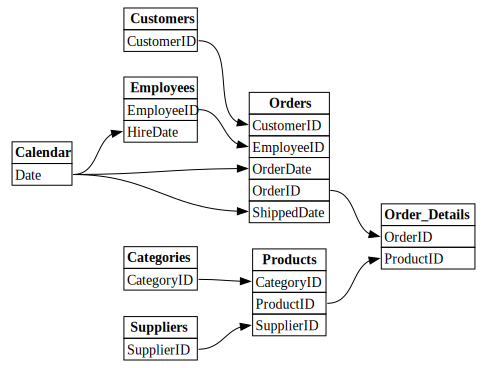

In [121]:
relationships = fabric.list_relationships(dataset["name"])
plot_relationship_metadata(relationships)

## Responses


#### **Day 01**: Which product/s has been ordered the most (in terms of quantity)?

##### [Video by Ruth with the response](https://youtu.be/_BhjrUWxriM?si=w6Wy8IthCyXGRVjr)

In [122]:
dax = """
    EVALUATE
        VAR _productsOrdered =
            ADDCOLUMNS (
                SUMMARIZE ( Order_Details, Products[ProductName] ),
                "@TotalQuantity", CALCULATE ( SUM ( Order_Details[Quantity] ) )
            )
        VAR _top1 = TOPN ( 1, _productsOrdered, [@TotalQuantity] )
        VAR _result = CONCATENATEX ( _top1, [ProductName], ", ", [ProductName] )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 1, dax)

┌───────────────────┬───────────────────────────────────────────────────────────────────────────┐
│ Question          │ Day 01: Which product/s has been ordered the most (in terms of quantity)? │
├───────────────────┼───────────────────────────────────────────────────────────────────────────┤
│ Expected response │ Camembert Pierrot                                                         │
├───────────────────┼───────────────────────────────────────────────────────────────────────────┤
│ My response       │ Camembert Pierrot                                                         │
├───────────────────┼───────────────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                                    │
└───────────────────┴───────────────────────────────────────────────────────────────────────────┘

#### **Day 02**: Which product/s has have the highest average order size?

##### [Video by Ruth with the response](https://youtu.be/h3kniqlIn5Y?si=zsbNCNe5YPRyzhYx)

In [123]:
dax = """
    EVALUATE
        VAR _productsOrdered =
            ADDCOLUMNS (
                SUMMARIZE ( Order_Details, Products[ProductName] ),
                "@AverageOrderSize", CALCULATE ( AVERAGE ( Order_Details[Quantity] ) )
            )
        VAR _top1 =
            TOPN ( 1, _productsOrdered, [@AverageOrderSize] )
        VAR _result =
            CONCATENATEX ( _top1, [ProductName], ", ", [ProductName] )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 2, dax)

┌───────────────────┬───────────────────────────────────────────────────────────────────┐
│ Question          │ Day 02: Which product/s has have the highest average order size?? │
├───────────────────┼───────────────────────────────────────────────────────────────────┤
│ Expected response │ Schoggi Schokolade                                                │
├───────────────────┼───────────────────────────────────────────────────────────────────┤
│ My response       │ Schoggi Schokolade                                                │
├───────────────────┼───────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                            │
└───────────────────┴───────────────────────────────────────────────────────────────────┘

#### **Day 03**: What is the highest average discount done to a product? (in %)

##### [Video by Ruth with the response](https://youtu.be/IWSm1EA8-Kw?si=awqt4UWwYdbWYvMk)

In [124]:
dax = """
    EVALUATE
        VAR _productsOrdered =
            ADDCOLUMNS (
                SUMMARIZE ( Order_Details, Products[ProductName] ),
                "@AverageDiscount", CALCULATE ( AVERAGE ( Order_Details[Discount] ) )
            )
        VAR _top1 =
            TOPN ( 1, _productsOrdered, [@AverageDiscount] )
        VAR _result =
            CONCATENATEX (
                _top1,
                FORMAT ( [@AverageDiscount], "0%" ),
                ", ",
                [@AverageDiscount], ASC
            )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 3, dax)

┌───────────────────┬────────────────────────────────────────────────────────────────────────┐
│ Question          │ Day 03: What is the highest average discount done to a product? (in %) │
├───────────────────┼────────────────────────────────────────────────────────────────────────┤
│ Expected response │ 25%                                                                    │
├───────────────────┼────────────────────────────────────────────────────────────────────────┤
│ My response       │ 25%                                                                    │
├───────────────────┼────────────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                                 │
└───────────────────┴────────────────────────────────────────────────────────────────────────┘

#### **Day 04**: Top 3 categories that have the highest revenue contribution

##### [Video by Ruth with the response](https://youtu.be/Z72XL9eZMgY?si=M2x-biwfTrptihl0)

In [125]:
dax = """
    EVALUATE
        VAR _categoriesAndRevenue =
            SUMMARIZECOLUMNS (
                Categories[CategoryName],
                "@CategoryRevenue",
                    SUMX (
                        Order_Details,
                        Order_Details[UnitPrice] * Order_Details[Quantity] * ( 1 - Order_Details[Discount] )
                    )
            )
        VAR _top1 =
            TOPN ( 3, _categoriesAndRevenue, [@CategoryRevenue] )
        VAR _result =
            CONCATENATEX ( _top1, Categories[CategoryName], ", ", [@CategoryRevenue], DESC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 4, dax)

┌───────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Question          │ Day 04: Top 3 categories that have the highest revenue contribution │
├───────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Expected response │ Beverages, Dairy Products, Confections                              │
├───────────────────┼─────────────────────────────────────────────────────────────────────┤
│ My response       │ Beverages, Dairy Products, Confections                              │
├───────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                              │
└───────────────────┴─────────────────────────────────────────────────────────────────────┘

#### **Day 05**: Average price of discountined products

##### [Video by Ruth with the response](https://youtu.be/xXlBpPdoaDo)

In [126]:
dax = """
    EVALUATE
        VAR _discountinedProductsAvgPrice =
            SUMMARIZECOLUMNS (
                Products[ProductID],
                TREATAS ( { TRUE () }, Products[Discontinued] ),
                "@AveragePrice", AVERAGEX ( Order_Details, Order_Details[UnitPrice] )
            )
        VAR _averageOfAvgPrices =
            AVERAGEX ( _discountinedProductsAvgPrice, [@AveragePrice] )
        VAR _result =
            FORMAT ( _averageOfAvgPrices, "#.00" )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 5, dax)

┌───────────────────┬────────────────────────────────────────────────┐
│ Question          │ Day 05: Average price of discountined products │
├───────────────────┼────────────────────────────────────────────────┤
│ Expected response │ 44.35                                          │
├───────────────────┼────────────────────────────────────────────────┤
│ My response       │ 44.35                                          │
├───────────────────┼────────────────────────────────────────────────┤
│ Result            │ PASSED                                         │
└───────────────────┴────────────────────────────────────────────────┘

#### **Day 06**: Percentage of sales of discountined products

##### [Video by Ruth with the response](https://youtu.be/PSaMaPfm2YA)

In [127]:
dax = """
    EVALUATE
        VAR _productSales =
            SUMMARIZECOLUMNS (
                Products[Discontinued],
                "@Sale",
                    SUMX (
                        Order_Details,
                        Order_Details[UnitPrice] * Order_Details[Quantity] * ( 1 - Order_Details[Discount] )
                    )
            )
        VAR _totalSales =
            SUMX ( _productSales, [@Sale] )
        VAR _discontinuedSales =
            SUMX ( FILTER ( _productSales, [Discontinued] = TRUE () ), [@Sale] )
        VAR _percentageDiscontinuedSales =
            DIVIDE ( _discontinuedSales, _totalSales )
        VAR _result =
            FORMAT ( _percentageDiscontinuedSales, "0%" )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 6, dax)

┌───────────────────┬──────────────────────────────────────────────────────┐
│ Question          │ Day 06: Percentage of sales of discountined products │
├───────────────────┼──────────────────────────────────────────────────────┤
│ Expected response │ 15%                                                  │
├───────────────────┼──────────────────────────────────────────────────────┤
│ My response       │ 15%                                                  │
├───────────────────┼──────────────────────────────────────────────────────┤
│ Result            │ PASSED                                               │
└───────────────────┴──────────────────────────────────────────────────────┘

#### **Day 07**: How many high-value orders wrer place in 1997?

##### [Video by Ruth with the response](https://youtu.be/puXvoqmwgWc)

In [128]:
dax = """
    EVALUATE
        VAR _ordersSales1997 =
            SUMMARIZECOLUMNS (
                Order_Details[OrderID],
                TREATAS ( { 1997 }, 'Calendar'[Year] ),
                "@OrderSales",
                    SUMX (
                        Order_Details,
                        Order_Details[UnitPrice] * Order_Details[Quantity] * ( 1 - Order_Details[Discount] )
                    )
            )
        VAR _averageOrderSales1997 =
            AVERAGEX ( _ordersSales1997, [@OrderSales] )
        VAR _ordersAboveAverageSale =
            FILTER ( _ordersSales1997, [@OrderSales] > _averageOrderSales1997 )
        VAR _result =
            COUNTROWS ( _ordersAboveAverageSale )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 7, dax)

┌───────────────────┬────────────────────────────────────────────────────────┐
│ Question          │ Day 07: How many high-value orders wrer place in 1997? │
├───────────────────┼────────────────────────────────────────────────────────┤
│ Expected response │ 145                                                    │
├───────────────────┼────────────────────────────────────────────────────────┤
│ My response       │ 145                                                    │
├───────────────────┼────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                 │
└───────────────────┴────────────────────────────────────────────────────────┘

#### **Day 08**: Number of orders delivered on time

##### [Video by Ruth with the response](https://youtu.be/oBicwum7bgU)

In [129]:
dax = """
    EVALUATE
        VAR _result = SUMX ( Orders, INT ( Orders[ShippedDate] == Orders[RequiredDate] ) )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 8, dax)

┌───────────────────┬────────────────────────────────────────────┐
│ Question          │ Day 08: Number of orders delivered on time │
├───────────────────┼────────────────────────────────────────────┤
│ Expected response │ 3                                          │
├───────────────────┼────────────────────────────────────────────┤
│ My response       │ 3                                          │
├───────────────────┼────────────────────────────────────────────┤
│ Result            │ PASSED                                     │
└───────────────────┴────────────────────────────────────────────┘

#### **Day 09**: Single month with highest sales

##### [Video by Ruth with the response](https://youtu.be/GNTyHo9bQKA)

In [130]:
dax = """
    EVALUATE
        VAR _ordersSalesByYearMonth =
            SUMMARIZECOLUMNS (
                'Calendar'[Year-Month],
                'Calendar'[Month Name],
                "@Sales",
                    SUMX (
                        Order_Details,
                        Order_Details[UnitPrice] * Order_Details[Quantity] * ( 1 - Order_Details[Discount] )
                    )
            )
        VAR _top1 =
            TOPN ( 1, _ordersSalesByYearMonth, [@Sales], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [Month Name], ", ", [Month Name], ASC )    
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 9, dax)

┌───────────────────┬─────────────────────────────────────────┐
│ Question          │ Day 09: Single month with highest sales │
├───────────────────┼─────────────────────────────────────────┤
│ Expected response │ Apr                                     │
├───────────────────┼─────────────────────────────────────────┤
│ My response       │ Apr                                     │
├───────────────────┼─────────────────────────────────────────┤
│ Result            │ PASSED                                  │
└───────────────────┴─────────────────────────────────────────┘

#### **Day 10**: Best sales date for queso cabrales

##### [Video by Ruth with the response](https://youtu.be/5XaqBkyFGow)

In [131]:
dax = """
    EVALUATE
        VAR _salesByDayQuesoCabrales =
            SUMMARIZECOLUMNS (
                'Calendar'[Day Name],
                TREATAS ( { "Queso Cabrales" }, Products[ProductName] ),
                "@Sales",
                    SUMX (
                        Order_Details,
                        Order_Details[UnitPrice] * Order_Details[Quantity] * ( 1 - Order_Details[Discount] )
                    )
            )
        VAR _top1 =
            TOPN ( 1, _salesByDayQuesoCabrales, [@Sales] )
        VAR _result =
            CONCATENATEX ( _top1, [Day Name], ", ", [Day Name], ASC )        
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 10, dax)

┌───────────────────┬────────────────────────────────────────────┐
│ Question          │ Day 10: Best sales date for queso cabrales │
├───────────────────┼────────────────────────────────────────────┤
│ Expected response │ Tue                                        │
├───────────────────┼────────────────────────────────────────────┤
│ My response       │ Tue                                        │
├───────────────────┼────────────────────────────────────────────┤
│ Result            │ PASSED                                     │
└───────────────────┴────────────────────────────────────────────┘

#### **Day 11**: Customer/s with the highest customer lifespan

##### [Video by Ruth with the response](https://youtu.be/VVND13GNmBM)

In [132]:
dax = """
    EVALUATE
        VAR _customersLifespan =
            SUMMARIZECOLUMNS (
                Customers[CompanyName],
                "@Lifespan",
                    VAR _minDate =
                        MINX ( Orders, Orders[OrderDate] )
                    VAR _maxDate =
                        MAXX ( Orders, Orders[OrderDate] )
                    RETURN
                        DATEDIFF ( _minDate, _maxDate, DAY )
            )
        VAR _top1 =
            TOPN ( 1, _customersLifespan, [@Lifespan], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [CompanyName], ", ", [CompanyName], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 11, dax)

┌───────────────────┬───────────────────────────────────────────────────────┐
│ Question          │ Day 11: Customer/s with the highest customer lifespan │
├───────────────────┼───────────────────────────────────────────────────────┤
│ Expected response │ Richter Supermarkt                                    │
├───────────────────┼───────────────────────────────────────────────────────┤
│ My response       │ Richter Supermarkt                                    │
├───────────────────┼───────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                │
└───────────────────┴───────────────────────────────────────────────────────┘

#### **Day 12**: Which customer/s has placed the most orders?

##### [Video by Ruth with the response](https://youtu.be/Sx26z_WxT48)

In [133]:
dax = """
    EVALUATE
        VAR _customersOrdersCount =
            SUMMARIZECOLUMNS (
                Customers[CompanyName],
                "@OrdersCount", COUNTROWS ( Orders )
            )
        VAR _top1 =
            TOPN ( 1, _customersOrdersCount, [@OrdersCount], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [CompanyName], ", ", [CompanyName], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 12, dax)

┌───────────────────┬──────────────────────────────────────────────────────┐
│ Question          │ Day 12: Which customer/s has placed the most orders? │
├───────────────────┼──────────────────────────────────────────────────────┤
│ Expected response │ Save-a-lot Markets                                   │
├───────────────────┼──────────────────────────────────────────────────────┤
│ My response       │ Save-a-lot Markets                                   │
├───────────────────┼──────────────────────────────────────────────────────┤
│ Result            │ PASSED                                               │
└───────────────────┴──────────────────────────────────────────────────────┘

#### **Day 13**: Top 5 countries with the highest number of customers

##### [Video by Ruth with the response](https://youtu.be/Uu3aoz5n9L0)

In [134]:
dax = """
    EVALUATE
        VAR _countriesCustomersWithOrdersCount =
            SUMMARIZECOLUMNS (
                Customers[Country],
                "@CustomersWithOrdersCount", DISTINCTCOUNT ( Orders[CustomerID] )
            )
        VAR _top5 =
            TOPN (
                5,
                _countriesCustomersWithOrdersCount,
                [@CustomersWithOrdersCount], DESC
            )
        VAR _result =
            CONCATENATEX ( _top5, [Country], ", ", [@CustomersWithOrdersCount], DESC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 13, dax)

┌───────────────────┬──────────────────────────────────────────────────────────────┐
│ Question          │ Day 13: Top 5 countries with the highest number of customers │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ Expected response │ USA, Germany, France, Brazil, UK                             │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ My response       │ USA, Germany, France, Brazil, UK                             │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                       │
└───────────────────┴──────────────────────────────────────────────────────────────┘

#### **Day 14**: Which customer/s placed the highest value of orders (in sales) in 1997?

##### [Video by Ruth with the response](https://youtu.be/_coDxizc3Co)

In [135]:
dax = """
    EVALUATE
        VAR _customersWithOrderSales =
            SUMMARIZECOLUMNS (
                Customers[CompanyName],
                TREATAS ( { 1997 }, 'Calendar'[Year] ),
                "@OrderSales",
                    SUMX (
                        Order_Details,
                        Order_Details[UnitPrice] * Order_Details[Quantity] * ( 1 - Order_Details[Discount] )
                    )
            )
        VAR _top1 =
            TOPN ( 1, _customersWithOrderSales, [@OrderSales], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [CompanyName], ", ", [CompanyName], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 14, dax)

┌───────────────────┬─────────────────────────────────────────────────────────────────────────────────┐
│ Question          │ Day 14: Which customer/s placed the highest value of orders (in sales) in 1997? │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────┤
│ Expected response │ QUICK-Stop                                                                      │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────┤
│ My response       │ QUICK-Stop                                                                      │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                                          │
└───────────────────┴─────────────────────────────────────────────────────────────────────────────────┘

#### **Day 15**: Customer/s with the highest number of orders in one single month

##### [Video by Ruth with the response](https://youtu.be/E1V-K6e3FGE)

In [136]:
dax = """
    EVALUATE
        VAR _customersOrdersByMonth =
            SUMMARIZECOLUMNS (
                Customers[CompanyName],
                'Calendar'[Year],
                'Calendar'[Month Number],
                "@Orders", COUNTROWS ( Orders )
            )
        VAR _top1 =
            TOPN ( 1, _customersOrdersByMonth, [@Orders], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [CompanyName], ", ", [CompanyName], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 15, dax)

┌───────────────────┬──────────────────────────────────────────────────────────────────────────┐
│ Question          │ Day 15: Customer/s with the highest number of orders in one single month │
├───────────────────┼──────────────────────────────────────────────────────────────────────────┤
│ Expected response │ Bottom-Dollar Markets, Ernst Handel, Save-a-lot Markets                  │
├───────────────────┼──────────────────────────────────────────────────────────────────────────┤
│ My response       │ Bottom-Dollar Markets, Ernst Handel, Save-a-lot Markets                  │
├───────────────────┼──────────────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                                   │
└───────────────────┴──────────────────────────────────────────────────────────────────────────┘

#### **Day 16**: Employee/s with the highest average order value (in sales)

##### [Video by Ruth with the response](https://youtu.be/X3cUC6-uRgM)

In [137]:
dax = """
    EVALUATE
        VAR _employeesWithAverageOrderSales =
            SUMMARIZECOLUMNS (
                Employees[Full Name],
                "@AverageOrderSales",
                    VAR _orderSales =
                        SUMX (
                            Order_Details,
                            Order_Details[UnitPrice] * Order_Details[Quantity] * ( 1 - Order_Details[Discount] )
                        )
                    VAR _orderCount =
                        COUNTROWS ( Orders )
                    RETURN
                        DIVIDE ( _orderSales, _orderCount )
            )
        VAR _top1 =
            TOPN ( 1, _employeesWithAverageOrderSales, [@AverageOrderSales], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [Full Name], ", ", [Full Name], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 16, dax)

┌───────────────────┬────────────────────────────────────────────────────────────────────┐
│ Question          │ Day 16: Employee/s with the highest average order value (in sales) │
├───────────────────┼────────────────────────────────────────────────────────────────────┤
│ Expected response │ Anne Dodsworth                                                     │
├───────────────────┼────────────────────────────────────────────────────────────────────┤
│ My response       │ Anne Dodsworth                                                     │
├───────────────────┼────────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                             │
└───────────────────┴────────────────────────────────────────────────────────────────────┘

#### **Day 17**: Employee/s with the langest avg processing order time

##### [Video by Ruth with the response](https://youtu.be/xrj6PZmnVyM)

In [138]:
dax = """
    EVALUATE
        VAR _employeesWithAverageProcessingTime =
            CALCULATETABLE (
                SUMMARIZECOLUMNS (
                    Employees[Full Name],
                    "@AverageProcessingTime", AVERAGEX ( Orders, Orders[ShippedDate] - Orders[OrderDate] )
                ),
                Orders[ShippedDate]
            )
        VAR _top1 =
            TOPN ( 1, _employeesWithAverageProcessingTime, [@AverageProcessingTime], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [Full Name], ", ", [Full Name], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 17, dax)

┌───────────────────┬───────────────────────────────────────────────────────────────┐
│ Question          │ Day 17: Employee/s with the langest avg processing order time │
├───────────────────┼───────────────────────────────────────────────────────────────┤
│ Expected response │ Anne Dodsworth                                                │
├───────────────────┼───────────────────────────────────────────────────────────────┤
│ My response       │ Anne Dodsworth                                                │
├───────────────────┼───────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                        │
└───────────────────┴───────────────────────────────────────────────────────────────┘

#### **Day 18**: Which employee has been in the company the longest?

##### [Video by Ruth with the response](https://youtu.be/2fhVSjcF7jU)

In [139]:
dax = """
    EVALUATE
        VAR _top1 =
            TOPN ( 1, Employees, Employees[HireDate], ASC )
        VAR _result =
            CONCATENATEX ( _top1, [Full Name], ", ", [Full Name], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 18, dax)

┌───────────────────┬─────────────────────────────────────────────────────────────┐
│ Question          │ Day 18: Which employee has been in the company the longest? │
├───────────────────┼─────────────────────────────────────────────────────────────┤
│ Expected response │ Janet Leverling                                             │
├───────────────────┼─────────────────────────────────────────────────────────────┤
│ My response       │ Janet Leverling                                             │
├───────────────────┼─────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                      │
└───────────────────┴─────────────────────────────────────────────────────────────┘

#### **Day 19**: Names of all Northwind managers

##### [Video by Ruth with the response](https://youtu.be/XfPSjast128)

In [140]:
dax = """
    EVALUATE
        VAR _managers =
            CALCULATETABLE (
                VALUES ( Employees[Full Name] ),
                TREATAS ( VALUES ( Employees[ReportsTo] ), Employees[EmployeeID] )
            )
        VAR _result =
            CONCATENATEX ( _managers, [Full Name], ", ", [Full Name], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 19, dax)

┌───────────────────┬───────────────────────────────────────────────┐
│ Question          │ Day 19: Names of all Northwind managers       │
├───────────────────┼───────────────────────────────────────────────┤
│ Expected response │ Andrew Fuller, Nancy Davolio, Steven Buchanan │
├───────────────────┼───────────────────────────────────────────────┤
│ My response       │ Andrew Fuller, Nancy Davolio, Steven Buchanan │
├───────────────────┼───────────────────────────────────────────────┤
│ Result            │ PASSED                                        │
└───────────────────┴───────────────────────────────────────────────┘

#### **Day 20**: Which employee/s handles most unique customers?

##### [Video by Ruth with the response](https://youtu.be/bGvc162r9hY)

In [141]:
dax = """
    EVALUATE
        VAR _employeesUniqueCustomers =
            SUMMARIZECOLUMNS (
                Employees[Full Name],
                "@UniqueCustomers", DISTINCTCOUNT ( Orders[CustomerID] )
            )
        VAR _top1 =
            TOPN ( 1, _employeesUniqueCustomers, [@UniqueCustomers], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [Full Name], ", ", [Full Name], ASC )    
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 20, dax)

┌───────────────────┬─────────────────────────────────────────────────────────┐
│ Question          │ Day 20: Which employee/s handles most unique customers? │
├───────────────────┼─────────────────────────────────────────────────────────┤
│ Expected response │ Margaret Peacock                                        │
├───────────────────┼─────────────────────────────────────────────────────────┤
│ My response       │ Margaret Peacock                                        │
├───────────────────┼─────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                  │
└───────────────────┴─────────────────────────────────────────────────────────┘

#### **Day 21**: Number of suppliers that deliver more products than average

##### [Video by Ruth with the response](https://youtu.be/TrNt93M7d3w)

In [142]:
dax = """
    EVALUATE
        VAR _providersProductsDelivered =
            SUMMARIZECOLUMNS (
                Suppliers[SupplierID],
                "@ProductsDelivered", COUNTROWS ( Products )
            )
        VAR _averageProductsDelivered =
            AVERAGEX ( _providersProductsDelivered, [@ProductsDelivered] )
        VAR _suppliersOverAverage =
            FILTER (
                _providersProductsDelivered,
                [@ProductsDelivered] > _averageProductsDelivered
            )
        VAR _result =
            COUNTROWS ( _suppliersOverAverage )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 21, dax)

┌───────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Question          │ Day 21: Number of suppliers that deliver more products than average │
├───────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Expected response │ 16                                                                  │
├───────────────────┼─────────────────────────────────────────────────────────────────────┤
│ My response       │ 16                                                                  │
├───────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                              │
└───────────────────┴─────────────────────────────────────────────────────────────────────┘

#### **Day 22**: Which supplier/s has the most out-of-stock products

##### [Video by Ruth with the response](https://youtu.be/nTE7eGnGuuw)

In [143]:
dax = """
    EVALUATE
        VAR _suppliersProductsOutOfStock =
            SUMMARIZECOLUMNS (
                Suppliers[CompanyName],
                "@ProductsOutOfStock", COUNTROWS ( FILTER ( Products, Products[UnitsInStock] = 0 ) )
            )
        VAR _top1 =
            TOPN ( 1, _suppliersProductsOutOfStock, [@ProductsOutOfStock], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [CompanyName], ", ", [CompanyName], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 22, dax)

┌───────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────┐
│ Question          │ Day 22: Which supplier/s has the most out-of-stock products                                 │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│ Expected response │ Formaggi Fortini s.r.l., G'day, Mate, New Orleans Cajun Delights, Pavlova, Ltd., Plutzer    │
│                   │ Lebensmittelgroßmärkte AG                                                                   │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│ My response       │ Formaggi Fortini s.r.l., G'day, Mate, New Orleans Cajun Delights, Pavlova, Ltd., Plutzer    │
│                   │ Lebensmittelgroßmärkte AG                                                                   │
├───────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                                                      │
└───────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────┘

#### **Day 23**: Which supplier delivers the most expensive product?

##### [Video by Ruth with the response](https://youtu.be/NBPepgMdN_c)

In [144]:
dax = """
    EVALUATE
        VAR _suppliersProductsUnitPrice =
            SELECTCOLUMNS (
                Products,
                "UnitPrice", Products[UnitPrice],
                "CompanyName", RELATED ( Suppliers[CompanyName] )
            )
        VAR _top1 =
            TOPN ( 1, _suppliersProductsUnitPrice, [UnitPrice], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [CompanyName], ", ", [CompanyName], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 23, dax)

┌───────────────────┬─────────────────────────────────────────────────────────────┐
│ Question          │ Day 23: Which supplier delivers the most expensive product? │
├───────────────────┼─────────────────────────────────────────────────────────────┤
│ Expected response │ Aux joyeux ecclésiastiques                                  │
├───────────────────┼─────────────────────────────────────────────────────────────┤
│ My response       │ Aux joyeux ecclésiastiques                                  │
├───────────────────┼─────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                      │
└───────────────────┴─────────────────────────────────────────────────────────────┘

#### **Day 24**: Which supplier has the highest category diversity?

##### [Video by Ruth with the response](https://youtu.be/zIodoIn1UpY)

In [145]:
dax = """
    EVALUATE
        VAR _suppliersCategories =
            SUMMARIZECOLUMNS (
                Suppliers[CompanyName],
                "@Categories", DISTINCTCOUNT ( Products[CategoryID] )
            )
        VAR _top1 =
            TOPN ( 1, _suppliersCategories, [@Categories], DESC )
        VAR _result =
            CONCATENATEX ( _top1, [CompanyName], ", ", [CompanyName], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 24, dax)

┌───────────────────┬────────────────────────────────────────────────────────────┐
│ Question          │ Day 24: Which supplier has the highest category diversity? │
├───────────────────┼────────────────────────────────────────────────────────────┤
│ Expected response │ Pavlova, Ltd., Plutzer Lebensmittelgroßmärkte AG           │
├───────────────────┼────────────────────────────────────────────────────────────┤
│ My response       │ Pavlova, Ltd., Plutzer Lebensmittelgroßmärkte AG           │
├───────────────────┼────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                     │
└───────────────────┴────────────────────────────────────────────────────────────┘

#### **Day 25**: Supplier with highest number of top 5 selling products

##### [Video by Ruth with the response](https://youtu.be/TL4XR9F_l0M)

In [146]:
dax = """
    EVALUATE
        VAR _productsOrdersQty =
            SUMMARIZECOLUMNS (
                Products[ProductID],
                Suppliers[CompanyName],
                "@OrdersQty", SUMX ( Order_Details, Order_Details[Quantity] )
            )
        VAR _top5Products =
            TOPN ( 5, _productsOrdersQty, [@OrdersQty], DESC )
        VAR _top5ProductsSupplierCount =
            GROUPBY (
                _top5Products,
                Suppliers[CompanyName],
                "@SupplierCount", COUNTX ( CURRENTGROUP (), 1 )
            )
        VAR _top1Supplier =
            TOPN ( 1, _top5ProductsSupplierCount, [@SupplierCount], DESC )
        VAR _result =
            CONCATENATEX ( _top1Supplier, [CompanyName], ", ", [CompanyName], ASC )
        RETURN { _result }
"""

execute_dax_and_print_results(dataset_id, 25, dax)

┌───────────────────┬────────────────────────────────────────────────────────────────┐
│ Question          │ Day 25: Supplier with highest number of top 5 selling products │
├───────────────────┼────────────────────────────────────────────────────────────────┤
│ Expected response │ Gai pâturage                                                   │
├───────────────────┼────────────────────────────────────────────────────────────────┤
│ My response       │ Gai pâturage                                                   │
├───────────────────┼────────────────────────────────────────────────────────────────┤
│ Result            │ PASSED                                                         │
└───────────────────┴────────────────────────────────────────────────────────────────┘